# Rationale

Reference: "Bayesian estimation of information-theoretic metrics for sparsely sampled distributions".

Link: https://arxiv.org/pdf/2301.13647

We have some counts $n$ sampled from a distribution $p(n|\rho)$ that depends on parameters $\rho$. In turn, these parameters are drawn from a distribution $p(\rho|\beta)$ that depends on some hyperparameter(s) $\beta$. The posterior over parameter values $p(\rho|n)$ can then be written as
$$\begin{eqnarray}
p(\rho|n) & = & \int d\beta \, p(\rho|n, \beta) \, p(\beta|n) \\
& = & \int d\beta \frac{p(n |\rho, \beta) \, p(\rho|\beta)}{p(n|\beta)} \, p(\beta|n)\\
& = & \int d\beta \frac{p(n |\rho) \, p(\rho|\beta)}{p(n|\beta)} \, p(\beta|n) \;.
\end{eqnarray}$$
In the last step, we have used that $n$ is independent of $\beta$ conditioned on $\rho$, that is, that $p(n |\rho, \beta) = p(n |\rho)$.

If the conditional distribution $p(\beta|n)$ is very peaked around a given value $\beta^*$ (that is, if $p(\beta|n)\approx \delta(\beta^*)$), then the posterior $p(\rho|n)$ can be approximated as
$$
p(\rho|n) \approx \frac{p(n |\rho) \, p(\rho|\beta^*)}{p(n|\beta^*)} \;,
$$
an approximation sometimes referred to as *empirical Bayes*, although in reality it is just a point estimate for the fully Bayesian hierarchical approach given by $p(n|\rho)$ and $p(\rho|\beta)$.

Within this approximation, the expected value of a function $F(\rho)$ over $\rho$ (for example, the entropy), is given by
$$
\langle F\rangle = \int d\rho \; F(\rho) p(\rho |n) \approx \int d\rho \; F(\rho) \frac{p(n |\rho) \, p(\rho|\beta^*)}{p(n|\beta^*)}\;.
$$

Here, we use this approximation, and estimate the value of the integral using MCMC to sample $\rho$ from $p(\rho|n)$. We use:
$$p(n|\rho) = \prod_i \rho_i^{n_i}$$
$$p(\rho|\beta) = \frac{\prod_i \rho_i^{\beta-1}}{B_K(\beta)}=\frac{\Gamma(\beta K) \prod_i \rho_i^{\beta-1} }{\Gamma(\beta)^K}$$

We do not need to calculate $p(n|\beta^*)$ because this does not depend on $\rho$, and it is thus not needed for our MCMC. 

# Preliminaries and helper functions

In [3]:
import sys
import os
import numpy as np
import pandas as pd
import scipy
import math
from scipy.special import loggamma, polygamma
from copy import deepcopy
from random import random, randint, sample, shuffle
from tqdm import tqdm
import warnings

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set(style='ticks', font_scale=1.4)

functions_dir_path = './functions/'
sys.path.append(functions_dir_path)

from beta_estim_funct import *
from nsb_funct import *


In [4]:
# results directory
project_dir = os.getcwd()
result_dir = project_dir + '/results/'
fig_dir = project_dir + '/figures/'

# Run code

In [5]:
def mkdf():
    df = pd.DataFrame({
        'K': df_K,
        'N' : df_N,
        'beta' : df_beta,
        'bstar' : df_bstar,
        'bstarNSB' : df_bstarNSB,
        'Strue' : df_Strue,
        'Sml' : df_Sml,
        'Sbay' : df_Sbay,
        'Sbay1' : df_Sbay1,
        'SbayNSB' : df_SbayNSB,
        'Shs' : df_Shs,
        'Sww':df_Sww,
        'SwwNSB':df_SwwNSB,
        'SNSB':df_SNSB,
    })
    
    # add columns to df: absolute difference between ground truth and simulations
    df['rel_bay'] = (df.Sbay - df.Strue)/df.Strue
    df['rel_bayNSB'] = (df.SbayNSB - df.Strue)/df.Strue
    df['rel_ml'] = (df.Sml - df.Strue)/df.Strue
    df['rel_hs'] = (df.Shs - df.Strue)/df.Strue
    df['rel_ww'] = (df.Sww- df.Strue)/df.Strue
    df['rel_wwNSB'] = (df.SwwNSB- df.Strue)/df.Strue
    df['rel_bay1'] = (df.Sbay1- df.Strue)/df.Strue
    df['rel_NSB'] = (df.SNSB - df.Strue)/df.Strue
  
    return df

In [9]:
Ks = [1000] # number of categories
BETAs = [0.01,1,10] # dirichlet parameter of true distribution
Ns = [30,40,50,60,80,100,500,1000,5000,10000] # sample sizes
NREP = 100 # repetitions: at each repetition a categorical distribution is generated, sampled and estimated from samples


In [ ]:

for K in Ks:
    for bb in range(len(BETAs)):
        BETA = BETAs[bb]
        filename = 'S_K%d_B%g' % (K, BETA)
        try:
            df = pd.read_csv(result_dir+filename+'.csv')
            ready = True
        except:
            ready = False        
        # If not done, do it
        if not ready:
            print('>>> K=%d  BETA=%s  ' % (K, str(BETA)), file=sys.stderr)
            df_N, df_K = [], []
            df_beta, df_bstar, df_bstarNSB = [], [], []
            df_Strue, df_Sbay,df_Sww, df_SwwNSB, df_Sbay1 = [], [], [], [], []
            df_Shs, df_SbayNSB,df_Smlcorr, df_Sml, df_SNSB = [], [], [], [], []
            
            for N in tqdm(Ns):
                for rep in range(NREP):

                    # ESTIMATION FOR FIRST DISTRIBUTION: 
                    # Generate the data, Estimate beta_1* (uniform hyper-prior), initialize values of rho for mcmc                            

                    multi, true_rhos, _, bstar, _,bstarNSB, _ = \
                            generate_data(K,N, BETA, niter = 20, add_zeroes=False)

                    # PARAMETERS
                    df_N.append(N)
                    df_K.append(K)
                    df_beta.append(BETA)
                    df_bstar.append(bstar)
                    df_bstarNSB.append(bstarNSB)
                    
                    # Shannon Entropies
                    Strue, Sml, Sbay, SNSB = entropy(true_rhos), ml_entropy(multi),bay_entropy(multi, bstar), round(nsb_entropy(np.array(multi))/np.log(K),16)
                    SbayNSB, Shs, Sbay1, Sww,SwwNSB = bay_entropy(multi, bstarNSB), hs_entropy(multi),bay_entropy(multi, 1.),ww_entropy(multi, bstar),ww_entropy(multi, bstarNSB)
                   
                    df_Strue.append(Strue), df_Sml.append(Sml),df_Sbay.append(Sbay), df_SNSB.append(SNSB)
                    df_SbayNSB.append(SbayNSB), df_Shs.append(Shs),df_Sbay1.append(Sbay1), df_Sww.append(Sww), df_SwwNSB.append(SwwNSB)                   
                          

            # Prepare and save the data frame        
            df = mkdf()
            
            ############################ SAVE DF ################################
            df.to_csv(result_dir+filename, index=False)
            #####################################################################



### plots

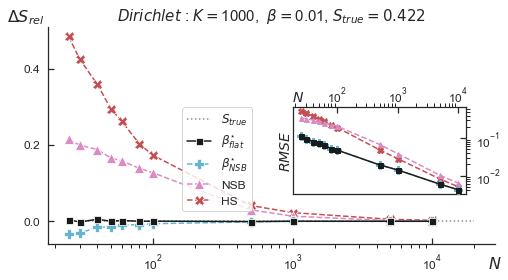

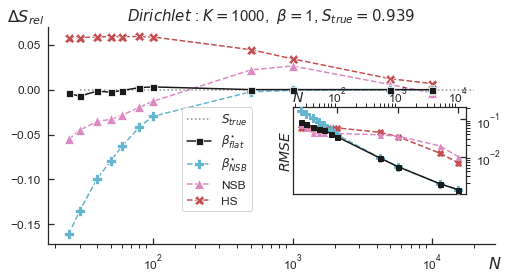

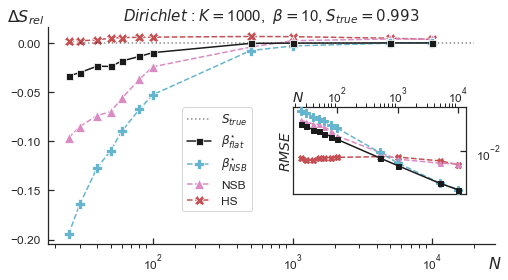

In [11]:
## add colums for MSE and inset

for K in Ks:
    for bb in range(len(BETAs)):
        BETA = BETAs[bb]
        filename = 'S_K%d_B%g' % (K, BETA)
        try:
            df = pd.read_csv(result_dir+filename+'.csv')
            ready = True
        except:
            ready = False
        # clean df from inf
        df_clean = df_cleaninf(df)
        # mean squared error
        df_clean['mse_bay'] = ((df_clean.Sbay - df_clean.Strue)/df.Strue)**2
        df_clean['mse_bayNSB'] =((df_clean.SbayNSB - df_clean.Strue)/df.Strue)**2
        df_clean['mse_ml'] = ((df_clean.Sml - df_clean.Strue)/df.Strue)**2
        df_clean['mse_hs'] = ((df_clean.Shs - df_clean.Strue)/df.Strue)**2
        df_clean['mse_bay1'] = ((df_clean.Sbay1 - df_clean.Strue)/df.Strue)**2
        df_clean['mse_ww'] = ((df_clean.Sww - df_clean.Strue)/df.Strue)**2
        df_clean['mse_wwNSB'] = ((df_clean.SwwNSB - df_clean.Strue)/df.Strue)**2
        df_clean['mse_NSB'] = ((df_clean.SNSB - df_clean.Strue)/df.Strue)**2
        
        
        ## PLOTS ##
        df_clean = df_clean[df_clean["N"] > 20]
        
        fig, ax = plt.subplots(figsize=[8,4])
        palette = sns.color_palette()
        
        S = df.mean()['Strue'] # S to legend is the average over nrep

        #         ax.plot((min(Ns)-5, max(Ns)+10000), (0, 0), 'k:',alpha=0.5, label=r'$S_{true} = %g$' %round(S,3))
        ax.plot((min(Ns), max(Ns)+10000), (0, 0), 'k:',alpha=0.5, label=r'$S_{true}$')

        sns.lineplot(x='N', y='rel_ww', data=df_clean,errorbar=None,
                     marker='s', label=r'$\beta^{\star}_{flat}$',zorder=5,color='k',markersize=7)
        sns.lineplot(x='N', y='rel_wwNSB', data=df_clean,errorbar=None,
                     linestyle = '--',marker='P', label=r'$\beta^{\star}_{NSB}$',zorder=4,color=palette[9],markersize=10)
        sns.lineplot(x='N', y='rel_NSB', data=df_clean,errorbar=None,
                     linestyle = '--', marker='^', label='NSB',zorder=3,color=palette[6],markersize=10)
        sns.lineplot(x='N', y='rel_hs', data=df_clean, errorbar=None,
                     linestyle = '--', marker='X', label='HS',zorder=0,color=palette[3],markersize=10)
        #         sns.lineplot(x='N', y='rel_bayNSB', data=df_clean,
        #                      marker='o', label='* MAP NSB',zorder=3,color=palette[0],markersize=7)
        #         sns.lineplot(x='N', y='rel_bay', data=df_clean,
        #                      marker='D', label='* MAP unif.',zorder=2,color=palette[1],markersize=7)
        #         sns.lineplot(x='N', y='rel_ml', data=df_clean,
        #                      marker='s', label='ML',zorder=1,color=palette[2],markersize=7)
        #         sns.lineplot(x='N', y='rel_bay1', data=df_clean,
        #                     marker='$o$', label= r'$\beta^*=1$',zorder=0,color=palette[4],markersize=7)


        ## title 
        ax.set_title(r'$Dirichlet$ : $K=$%d,  $\beta=$%s, $S_{true} = %g$' % (K, str(BETA),round(S,3)), fontsize=15, x=0.5, y=1)
        ## axis labels and ticks
        ax.set_ylabel(r'$\Delta S_{rel}$', rotation = 0,fontsize=16) # \frac{\overline{S}-S}{S}
        ax.yaxis.set_label_coords(-.05, 1)
        ax.set_xlabel(r'$N$', rotation = 0,fontsize=16)
        ax.xaxis.set_label_coords(1, -.05)
        ax.locator_params(axis='y', nbins=5) # number of ticks

        sns.despine() # hide up and right borders
        plt.xscale('log')

        ax.tick_params(axis="y",direction="in", pad=+8, labelsize=12)
        ax.tick_params(axis="x",direction="in", pad=+8, labelsize=12)

        ## legend

        ax.legend(loc='lower left', bbox_to_anchor=(0.3,0.15), borderaxespad=0,prop={'size': 12},frameon=True,facecolor="white") # title = 'S='+str(round(S,3)),title_fontsize=12


        
        ## INSET ##

        # These are in unitless percentages of the figure size. (0,0 is bottom left)
        left, bottom, width, height = [.55, .3, 0.3, 0.3]
        ax2 = fig.add_axes([left, bottom, width, height])

        mse_HS = np.sqrt(df_clean.groupby('N').mean()['mse_hs'])
        x = mse_HS.index
        plt.plot(x, mse_HS, linestyle = '--',marker='X', label='HS',zorder=0,color=palette[3],markersize=6)

        std_NSB = np.sqrt(df_clean.groupby('N').mean()['mse_NSB'])
        plt.plot(x, std_NSB, linestyle = '--',marker='^', label='NSB',zorder=3,color=palette[6],markersize=5)

        std_ww = np.sqrt(df_clean.groupby('N').mean()['mse_ww'])
        plt.plot(x, std_ww, marker='s', label=r'$\star$ unif.',zorder=5,color='k',markersize=5)

        std_wwNSB = np.sqrt(df_clean.groupby('N').mean()['mse_wwNSB'])
        ax2.plot(x, std_wwNSB, linestyle = '--', marker='P', label=r'$\star$ NSB',zorder=4,color=palette[9],markersize=8)

        #         sns.lineplot(x='N', y='rel_bayNSB', data=df_clean,
        #                      marker='o', label='* MAP NSB',zorder=3,color=palette[0],markersize=7)
        #         sns.lineplot(x='N', y='rel_bay', data=df_clean,
        #                      marker='D', label='* MAP unif.',zorder=2,color=palette[1],markersize=7)
        #         sns.lineplot(x='N', y='rel_ml', data=df_clean,
        #                      marker='s', label='ML',zorder=1,color=palette[2],markersize=7)
        #         sns.lineplot(x='N', y='rel_bay1', data=df_clean,
        #                     marker='$o$', label= r'$\beta^*=1$',zorder=0,color=palette[4],markersize=7)
        
        ## axis labels and ticks
        ax2.set_ylabel(r'$RMSE$', rotation = 90,fontsize=14) # \frac{\overline{S}-S}{S}
        ax2.yaxis.set_label_coords(0, .5)
        ax2.set_xlabel(r'$N$', rotation = 0,fontsize=14)
        ax2.xaxis.set_label_coords(0.03, 1.2)
        
        ax2.tick_params(axis="y",direction="in", pad=+10, labelsize=12)
        ax2.tick_params(axis="x",direction="in", pad=+2, labelsize=12)
        ax2.xaxis.set_ticks_position('top')
        ax2.yaxis.set_ticks_position('right') 

        ax2.set_xscale('log')
        ax2.set_yscale('log')

        plt.show()
